<a href="https://colab.research.google.com/github/ninja-codes-droid/Machine_learning_project/blob/master/Potential%20Lungs%20Disease%20Detection%20Using%20Chest%20X-RAY/Potential_Lungs_Disease_Detection_Using_Chest_X_RAY_Dense_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Potential Lungs Disease Detection Using Chest-X-Ray with Dense-Net Model**

##Importing Libraries

In [ ]:
import numpy as np # For Data processing
import os
import tensorflow as tf
import tensorflow.keras as tk  # For Model processing 
import seaborn as sns  # Python data visualization library based on matplotlib
import matplotlib.pyplot as plt  # For Data Visualization
from tensorflow.keras.preprocessing.image import ImageDataGenerator # For Data Preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Conv2D, concatenate, AvgPool2D, GlobalAveragePooling2D,ReLU,MaxPool2D
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, TensorBoard ,ReduceLROnPlateau#For Getting The Best Model
from tensorflow.keras.optimizers import Adam # Optimizer 
from sklearn.metrics import classification_report,confusion_matrix # Generating Confusion matrix and classification_report of matrix 
from sklearn.metrics import RocCurveDisplay,ConfusionMatrixDisplay # Model Evaluation Visualization
from sklearn.metrics import roc_curve, auc  #For ploting Roc And AUC curve
from sklearn.preprocessing import label_binarize # For binazing labels to plot curves
from keras.utils.vis_utils import plot_model # Display Model summery

## Data Acquisition
###### This is a Lungs Disease Dataset from kaggle authored by omkarmanohardalvi(https://www.kaggle.com/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types) ,The Dataset contains chest x-rays images. This Dataset was prepared from various datasets like he combined the datasets accordingly . It has 4 types of Lungs Diseases and a folder of Normal Lungs. He augmented the dataset with factor 6 so there are basically 10000 images.

### Download Dataset From Kaggle


In [ ]:
# Install Kaggle Supporting Python Library
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Mount Google Drive To Get The Kaggle Credentials
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create A Temporary Storage To Store The Kaggle Credentials Into Root 
! mkdir ~/.kaggle

In [ ]:
#Copy The Credentials From Google Drive To Temporary Storage
! cp '/content/drive/MyDrive/Colab Notebooks/Kaggle cred/kaggle.json' ~/.kaggle/kaggle.json

In [ ]:
# Checking For The Credentials File
! ls -a /root/.kaggle

.  ..  kaggle.json


In [ ]:
#Changing The Credentials File To Owner Only
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Downloading The Dataset From Kaggle 
! kaggle datasets download omkarmanohardalvi/lungs-disease-dataset-4-types

100% 2.02G/2.02G [01:20<00:00, 21.6MB/s]
100% 2.02G/2.02G [01:20<00:00, 26.9MB/s]


In [ ]:
#Unzip The Dataset 
! unzip /content/lungs-disease-dataset-4-types.zip

Streaming output truncated to the last 5000 lines.
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0673-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0675-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0678-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0680-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0682-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0683-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0684-0001-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0686-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0690-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0692-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0693-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0695-0001.jpeg  
  inflating: Lung Disease Dataset/train/Norm

###Data Preprocessing

####Analysing the Dataset

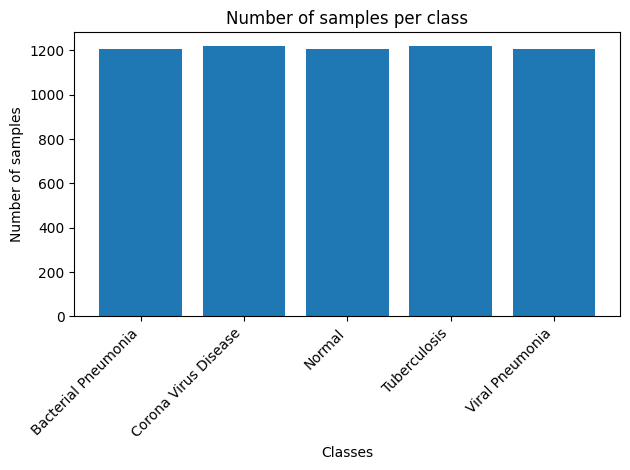

In [ ]:
classes = ["Bacterial Pneumonia", "Corona Virus Disease", "Normal", "Tuberculosis", "Viral Pneumonia"]

counts = {}
for c in classes:
    counts[c] = len(os.listdir("/content/Lung Disease Dataset/train/" + c))

plt.xlabel("Classes")
plt.ylabel("Number of samples")
plt.title("Number of samples per class")
plt.bar(x=counts.keys(), height=counts.values())

plt.xticks(rotation=45, ha='right', fontsize=10)  # Increase the x-axis label size and rotate them for better readability, ha aligns the lables 
plt.tight_layout()  # Adjust the spacing of the plot elements to prevent labels from being cut off

plt.show()

#### Image Data Processing 

In [ ]:
#Assigning Image Folders To Corresponding Variables 
train_dataset_path = '/content/Lung Disease Dataset/train'
validation_dataset_path ='/content/Lung Disease Dataset/val'
test_dataset_path = '/content/Lung Disease Dataset/test'

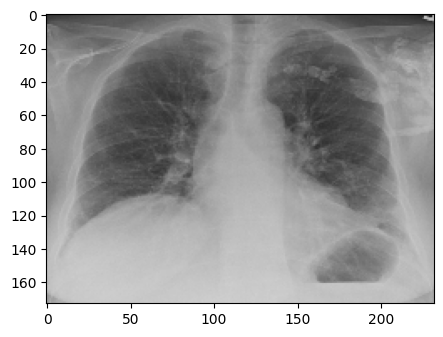

In [ ]:
# simply show a picture
plt.figure(figsize= (5, 5))
img = plt.imread("/content/Lung Disease Dataset/train/Corona Virus Disease/00030347_000.png")
plt.imshow(img)
plt.show()

In [ ]:
#Create Augmented Images With Below Variables
datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 40,
                                                                  width_shift_range = 0.2,
                                                                  height_shift_range = 0.2,
                                                                  horizontal_flip = True,
                                                                  )
#This generator reads images from train dataset and 
# create batches of augmented image data 
training_data  = datagen.flow_from_directory(train_dataset_path
                                                      ,target_size=(224,224),batch_size = 128,class_mode = 'categorical')

Found 6054 images belonging to 5 classes.


In [ ]:
# This generator reads images from validation ,test dataset and 
# create batches of augmented image data 

validation_data  = datagen.flow_from_directory(validation_dataset_path,target_size=(224,224),
                                                                                              batch_size = 128,class_mode = 'categorical')
test_data  = datagen.flow_from_directory(test_dataset_path,target_size=(224,224),
                                                                                              batch_size = 128,class_mode = 'categorical')

Found 2016 images belonging to 5 classes.
Found 2025 images belonging to 5 classes.


In [ ]:
# To Display The Dictionary Of Class
training_data.class_indices

{'Bacterial Pneumonia': 0,
 'Corona Virus Disease': 1,
 'Normal': 2,
 'Tuberculosis': 3,
 'Viral Pneumonia': 4}

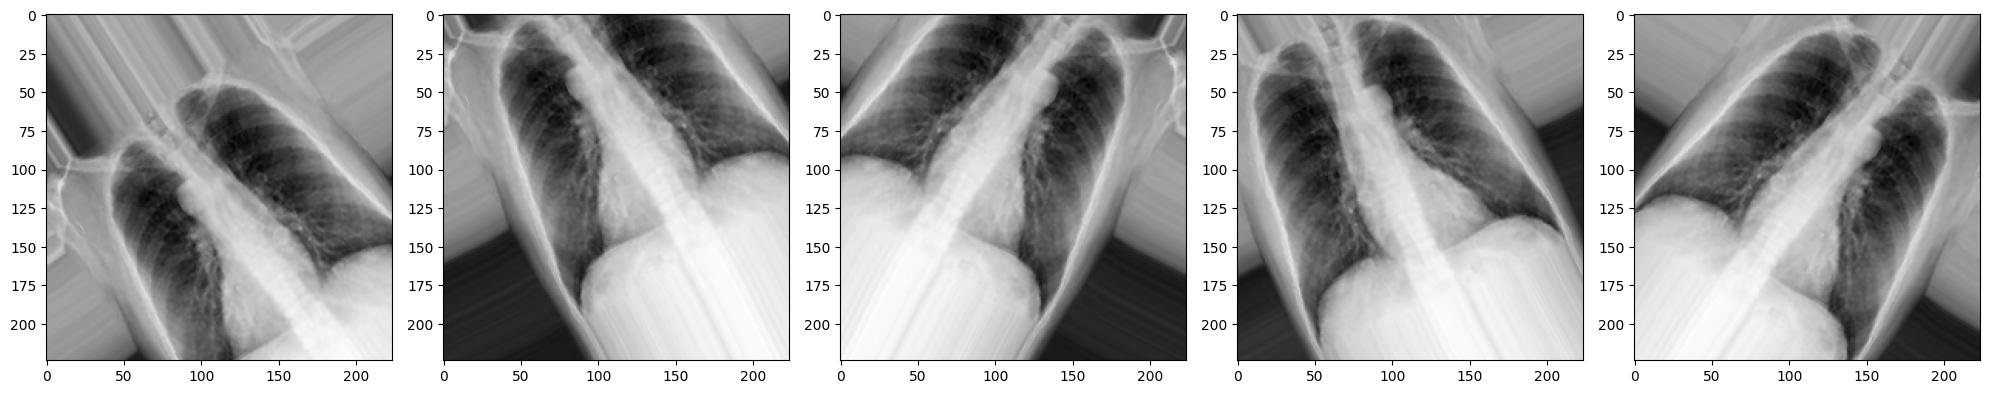

In [ ]:
# To Display The Augmented Images
def plotImages(image_arr):
    fig, axes  = plt.subplots(1,5,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(image_arr, axes):
          ax.imshow(img)
    plt.tight_layout()
    plt.show()
images = [training_data[0][0][0] for i in range(5)]
plotImages(images)

##Model Building
###### A convolutional neural network (CNN) is a type of deep learning algorithm used for image recognition and processing of pixel data. Unlike other neural networks, CNNs are specifically designed for object recognition tasks, making them ideal for computer vision applications like self-driving cars and facial recognition. While there are other types of neural networks in deep learning, CNNs are the preferred choice for identifying and recognizing objects.A DenseNet is a type of convolutional neural network that utilises dense connections between layers, through Dense Blocks, where we connect all layers (with matching feature-map sizes) directly with each other. To preserve the feed-forward nature, each layer obtains additional inputs from all preceding layers and passes on its own feature-maps to all subsequent layers.In DenseNet, each layer obtains additional inputs from all preceding layers and passes on its own feature-maps to all subsequent layers. Concatenation is used. Each layer is receiving a “collective knowledge” from all preceding layers.

### Dense Net Model 

In [ ]:
# Function for Dense Net (Dense Net 121) CNN Model
def densenet(input_shape,n_classes,nfilter = 32) :
  def   bn_relu_conv(x,nfilter,kernel=1,strides=1) : 
    #Batch Normalization relu convolution where x is input Variable
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(nfilter,kernel,strides = strides ,padding = 'same' )(x)
    return x
  def dense_block(x,repetitions):
    for _ in range(repetitions):
      y = bn_relu_conv(x,4*nfilter)
      y = bn_relu_conv(x,nfilter,kernel = 3)
      x = concatenate([y,x])
    return x
  def transition_layer (x) :
    # in transition layer we reduce channels to half of existing
    x = bn_relu_conv(x,K.int_shape(x)[-1]//2)
    x = AvgPool2D(2,strides = 2, padding = 'same')(x)
    return x
  
  input = Input(input_shape)
  x = Conv2D(64,7,strides = 2,padding = 'same' )(input)                 # Initial Convolution Layer
  x = MaxPool2D(3,strides = 2,padding = 'same')(x)                       # Initial Max Pooling Layer
  for r in [6,12,24,16] :
    d = dense_block(x,r)                                                                             
    x = transition_layer(d)
  x = GlobalAveragePooling2D()(d)                                                 # GlobalAveragePooling of the final dense layer
  output = Dense(n_classes,activation = 'softmax')(x)                      # Generating output

  model = Model(input,output)
  return model


In [ ]:
# Inserting Image Shapes and Calling Model Functions
input_shape = 224,224,3            # Shape of The Image
n_classes = 5                              # Number of Output Classes

K.clear_session()                       # Clearing Previous session (if any)
model = densenet(input_shape,n_classes) # Calling the DenseNet Model function
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']                 
                                                                                              

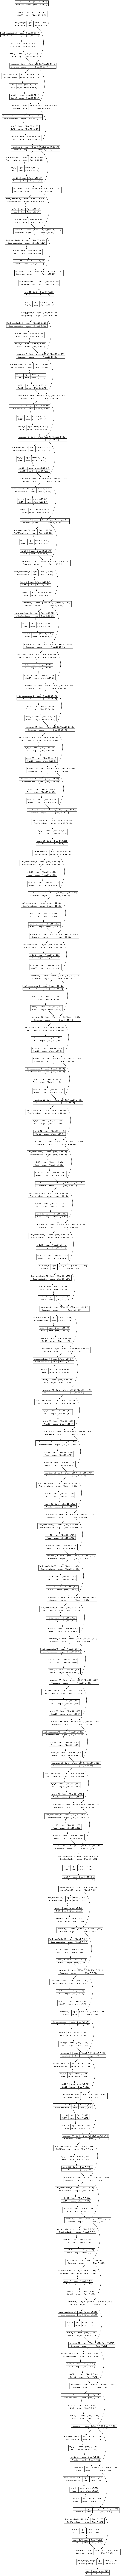

In [ ]:
#Visualizing Model Using Keras
plot_model(model, to_file='/content/drive/MyDrive/Colab Notebooks/Densenet/Modeldetails/model_flow.png', show_shapes=True, show_layer_names=True)

### Compiling And Training Model

#### Prevention Of Overfitting

In [ ]:
# Saving The Model With Maximum Validation Accuracy
Checkpoint = tk.callbacks.ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Densenet/Checkpoints/Detect_model_dense_net-{epoch:02d}-{val_accuracy:.4f}.h5", monitor="val_accuracy", save_best_only= True, mode="max",verbose =1)
reduce_lr = ReduceLROnPlateau(monitor= "val_accuracy", factor= 0.5, patience= 3, verbose= 3,cooldown=2,  mode= "max", min_lr= 0.0000001)

#### Compiling Model & Training


In [ ]:
# determining of available resources, if GPU is available for training or not
if tf.test.gpu_device_name():
    device = '/GPU:0'
else:
    device = '/CPU:0'

print(f"Training model on {device[1:-2]}")

with tf.device(device):
  # Compiling With High Learning Rate
  model.compile(optimizer  = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
  history=model.fit(training_data, epochs=85, verbose=1, callbacks=[reduce_lr, Checkpoint],validation_data=validation_data,batch_size=128)

Training model on GPU
Epoch 1/85
48/48 [==============================] - ETA: 0s - loss: 2.1794 - accuracy: 0.4724
Epoch 1: val_accuracy improved from -inf to 0.19891, saving model to /content/drive/MyDrive/Colab Notebooks/Densenet/Checkpoints/Detect_model_dense_net-01-0.1989.h5
48/48 [==============================] - 337s 5s/step - loss: 2.1794 - accuracy: 0.4724 - val_loss: 9.1956 - val_accuracy: 0.1989 - lr: 0.0010
Epoch 2/85
48/48 [==============================] - ETA: 0s - loss: 0.9356 - accuracy: 0.6340
Epoch 2: val_accuracy improved from 0.19891 to 0.20040, saving model to /content/drive/MyDrive/Colab Notebooks/Densenet/Checkpoints/Detect_model_dense_net-02-0.2004.h5
48/48 [==============================] - 233s 5s/step - loss: 0.9356 - accuracy: 0.6340 - val_loss: 3.9919 - val_accuracy: 0.2004 - lr: 0.0010
Epoch 3/85
48/48 [==============================] - ETA: 0s - loss: 0.9493 - accuracy: 0.6166
Epoch 3: val_accuracy improved from 0.20040 to 0.26587, saving model to /cont

## Model Evaluation
######Model evaluation is the process of using different evaluation metrics to understand a machine learning model’s performance, as well as its strengths and weaknesses. Model evaluation is important to assess the efficacy of a model during initial research phases, and it also plays a role in model monitoring.

###Ploting Charts On Training Data Over Validation Data

####Plotting The Losses Over Training


[]

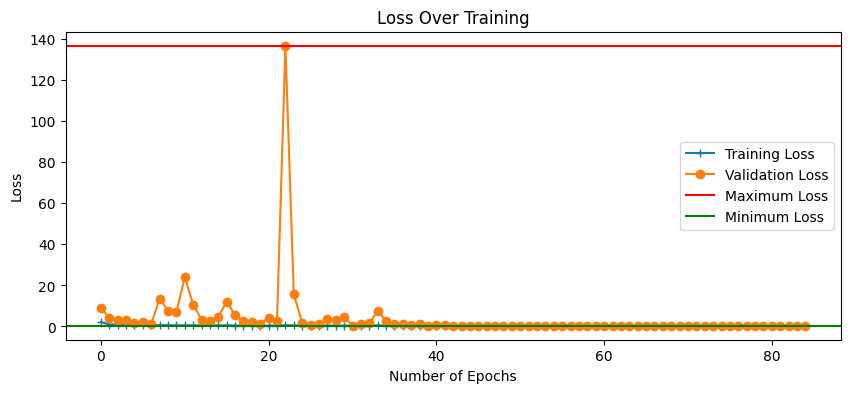

In [ ]:
plt.figure(figsize=(10, 4))

plt.title("Loss Over Training")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")

plt.plot(history.history['loss'], label='Training Loss', marker="+")
plt.plot(history.history['val_loss'], label='Validation Loss', marker="o")

max_loss = max(max(history.history['loss']), max(history.history['val_loss']))
plt.axhline(max_loss, color="red", label="Maximum Loss")

min_loss = min(min(history.history['loss']), min(history.history['val_loss']))
plt.axhline(min_loss, color="green", label="Minimum Loss")

plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Densenet/Modeldetails/loss over training.png', transparent=True, dpi=500)
plt.plot()

#### Plotting the accuracy over training


[]

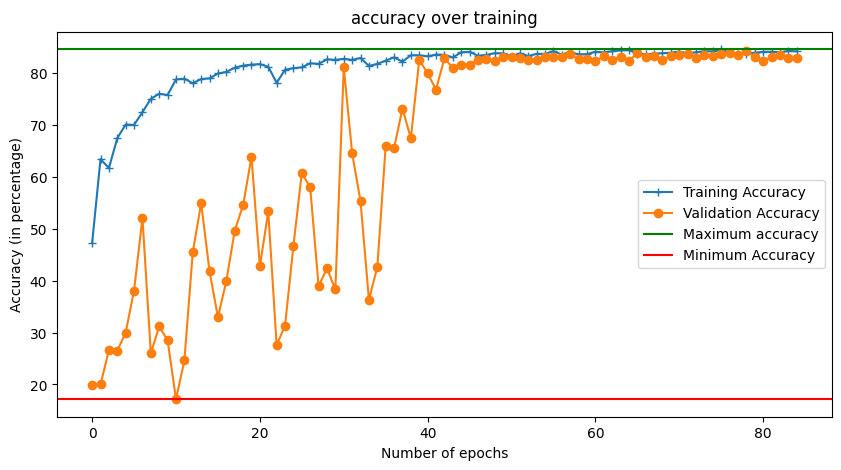

In [ ]:
plt.figure(figsize=(10, 5))

plt.title("accuracy over training")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy (in percentage)")

plt.plot(100 * np.array(history.history['accuracy']), label='Training Accuracy', marker="+")
plt.plot(100 * np.array(history.history['val_accuracy']), label='Validation Accuracy', marker="o")

max_acc = 100 * max(max(history.history['accuracy']), max(history.history['val_accuracy']))
plt.axhline(max_acc, color="green", label="Maximum accuracy")

min_acc = 100 * min(min(history.history['accuracy']), min(history.history['val_accuracy']))
plt.axhline(min_acc, color="red", label="Minimum Accuracy")

plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Densenet/Modeldetails/accuracy over training.png', transparent=True, dpi=500)
plt.plot()

### Evaluation On Test Data Set


#### Accuracy On Test Data Set

In [ ]:
test_loss, test_acc = model.evaluate(test_data, verbose=2)
print('Test accuracy:', test_acc)

16/16 - 66s - loss: 0.3984 - accuracy: 0.8370 - 66s/epoch - 4s/step
Test accuracy: 0.8370370268821716


#### ROC-AUC Curve 
######(Receiver Operating Characteristic curve & Area Under the ROC Curve)
######An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives
 ###### The higher the AUC, the better the model's performance at distinguishing between the positive and negative classes

[]

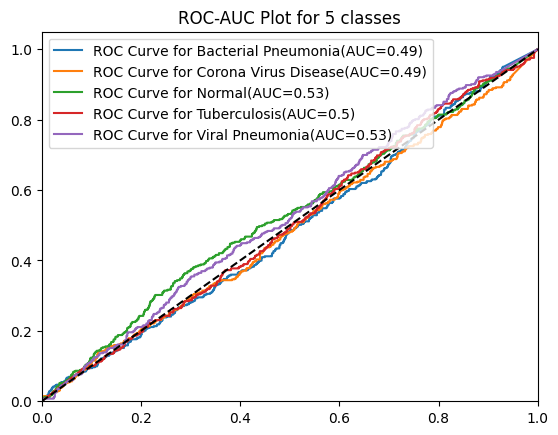

In [ ]:
# Labels of The Image Folder/Types
labels = ["Bacterial Pneumonia", "Corona Virus Disease", "Normal", "Tuberculosis", "Viral Pneumonia"]
#for multi-class 
# True and Predicted labels 
y_true = test_data.classes
y_true = label_binarize(y_true, classes=[0, 1, 2, 3,4])

y_pred = model.predict(test_data, verbose=0)

FPR, TPR, ROC_AUC, THRESHOLDS = {}, {}, {}, []

for i in range(5):
    FPR[i], TPR[i], THRESHOLDS = roc_curve(y_true[:, i], y_pred[:, i])
    ROC_AUC[i] = auc(FPR[i], TPR[i])

for i in range(5):
    plt.plot(FPR[i], TPR[i], label=f"ROC Curve for {labels[i]}(AUC={round(ROC_AUC[i], 2)})")
    plt.legend()

plt.title("ROC-AUC Plot for 5 classes")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Densenet/Modeldetails/ROC-AUC.png', transparent=True, dpi=500)
plt.plot()

#### Confusion Matrix

In [ ]:
y_pred=np.argmax(y_pred, axis=1)       # Predicted Values
y_true=np.argmax(y_true, axis=1)         # Actual Values
cm = confusion_matrix(y_true, y_pred) # Generate Confusion Matrix
print(cm) 

[[72 78 83 96 74]
 [75 84 89 91 68]
 [71 85 99 77 72]
 [86 80 65 81 96]
 [85 81 87 69 81]]


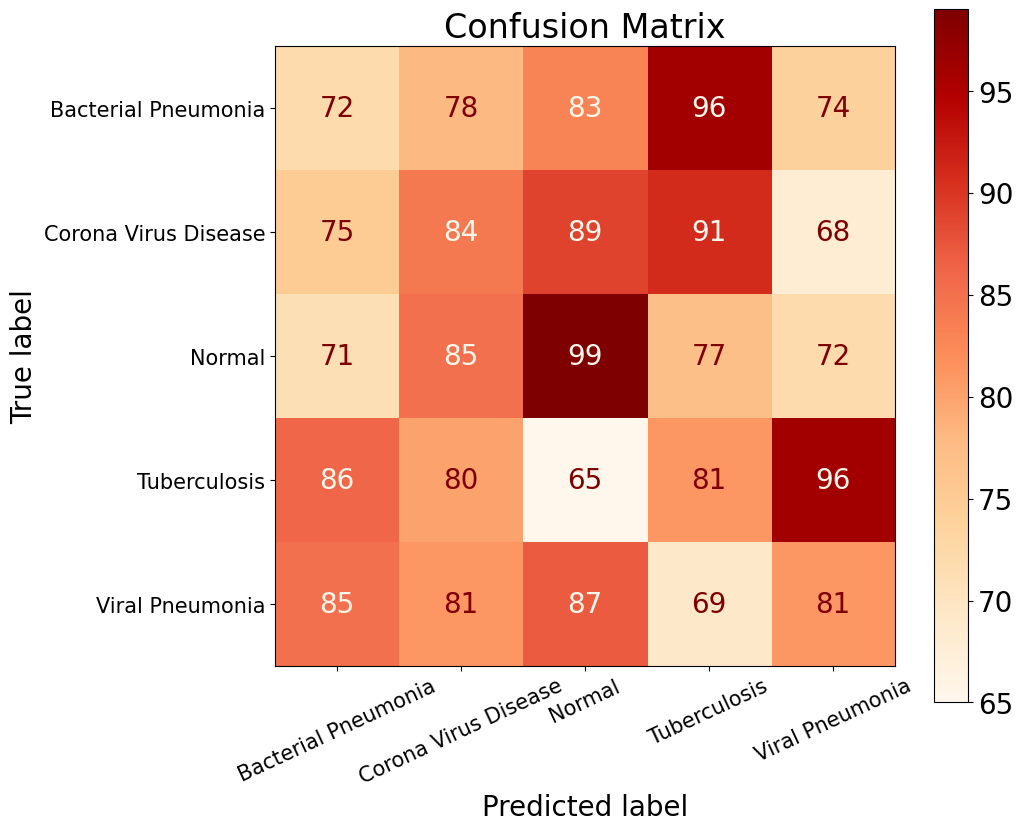

In [ ]:
# Generating Confusion Matrix in Visual Format
# Setting default size of the plot
# Setting default fontsize used in the plot
plt.rcParams['figure.figsize'] = (10.0, 9.0)
plt.rcParams['font.size'] = 20


# Implementing visualization of Confusion Matrix
display_c_m = ConfusionMatrixDisplay(cm, display_labels=labels)


# Plotting Confusion Matrix
# Setting colour map to be used
display_c_m.plot(cmap='OrRd', xticks_rotation=25)
# Other possible options for colour map are:
# 'autumn_r', 'Blues', 'cool', 'Greens', 'Greys', 'PuRd', 'copper_r'


# Setting fontsize for xticks and yticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


# Giving name to the plot
plt.title('Confusion Matrix', fontsize=24)


# Saving plot
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Densenet/Modeldetails/confusion_matrix.png', transparent=True, dpi=500)


# Showing the plot
plt.show()

##Saving The Model

In [ ]:
#Saving The Model In Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/Densenet/Detect_Model_Dense_net_121.h5'
model.save(path)  # to save in google drive